
# APUNTES OpenCV — `cv.findContours()` 
---
La función **`cv.findContours()`** es una de las más importantes en **OpenCV**  
y se utiliza para **detectar bordes y formas** dentro de una **imagen binaria**  
(blanco y negro).

Se usa para:
- Detectar objetos  
- Reconocer figuras  
- Analizar áreas y perímetros  
- Procesamiento de imágenes

---

## Sintaxis básica

```python
contours, hierarchy = cv.findContours(
    imagen_binaria,
    modo,
    metodo
)


-----------------
Fai un programa en Python que coa imaxe escaneada:

- Identifica os cuadrilateros da imaxe.

- Conta o número de "circulos" e encerraos dentro dun cuadrilatero

Cuadriláteros resaltados en verde.
Círculos contados: 0 (encerrados en azul).


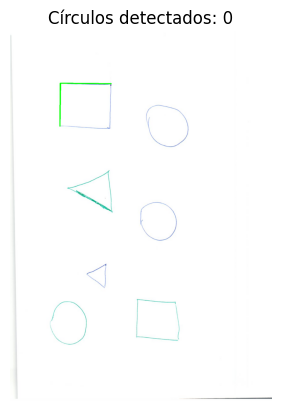

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 1. CARGA Y PREPARACIÓN (Fase 1 mejorada)
img = cv.imread("../../docs/Escaneo-cargador.jpg")

if img is None:
    print("ERROR: No se pudo abrir la imagen.")
else:
    # Pasamos a gris
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # IMPORTANTE: Umbralizado (Threshold) 
    # Usamos THRESH_BINARY_INV porque los dibujos suelen ser oscuros sobre papel claro
    # Esto deja el dibujo en blanco y el fondo en negro para OpenCV
    _, thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY_INV)

    # 2. BUSCAR CONTORNOS
    cnts, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Creamos una copia para dibujar encima
    imagen_final = img.copy()
    
    num_circulos = 0

    # 3. ANALIZAR CADA FORMA (Fase 2 y 3)
    for c in cnts:
        # Calculamos área y perímetro (según tus apuntes)
        area = cv.contourArea(c)
        perimeter = cv.arcLength(c, True)
        
        if area < 100: continue # Ignorar ruidito pequeño

        # --- LÓGICA DE CUADRILÁTEROS ---
        # Aproximamos el polígono
        # El 0.02 es la precisión; si el resultado tiene 4 puntos, es un cuadrilátero
        approx = cv.approxPolyDP(c, 0.02 * perimeter, True)
        
        if len(approx) == 4:
            # Dibujamos el cuadrilátero en VERDE
            cv.drawContours(imagen_final, [approx], 0, (0, 255, 0), 3)

        # --- LÓGICA DE CÍRCULOS (Circularidad) ---
        if perimeter > 0:
            # Fórmula de tus apuntes: 4 * pi * (Area / Perímetro^2)
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            
            # Un círculo perfecto es 1.0. En escaneos, 0.7 o 0.8 está bien.
            if circularity > 0.8:
                num_circulos += 1
                
                # "Encerrarlo dentro dun cuadrilatero": Bounding Box
                x, y, w, h = cv.boundingRect(c)
                cv.rectangle(imagen_final, (x, y), (x + w, y + h), (255, 0, 0), 2) # Azul

    # 4. RESULTADOS
    print(f"Cuadriláteros resaltados en verde.")
    print(f"Círculos contados: {num_circulos} (encerrados en azul).")

    # Mostrar con Matplotlib (convertir BGR a RGB)
    plt.imshow(cv.cvtColor(imagen_final, cv.COLOR_BGR2RGB))
    plt.title(f"Círculos detectados: {num_circulos}")
    plt.axis('off')
    plt.show()
    

In [1]:
import cv2
import numpy as np

def procesar_formas_final(ruta_imagen):
    # 1. Cargar imagen
    img = cv2.imread(ruta_imagen)
    if img is None:
        print("Error: No se encuentra la imagen.")
        return

    img_resultado = img.copy()
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Pre-procesamiento (Mantenemos el que funcionaba bien)
    limiar = cv2.adaptiveThreshold(
        gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Engrosar líneas para cerrar huecos
    kernel = np.ones((4, 4), np.uint8)
    limiar = cv2.morphologyEx(limiar, cv2.MORPH_CLOSE, kernel)
    limiar = cv2.dilate(limiar, kernel, iterations=1)

    # 3. Encontrar contornos
    contornos, _ = cv2.findContours(limiar, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contador_circulos = 0
    print(f"Analizando {len(contornos)} formas...")

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        
        # Ignorar ruido pequeño
        if area < 1000: 
            continue

        # Usamos convexHull para "envolver" el dibujo y eliminar picos raros
        hull = cv2.convexHull(contorno)
        perimetro = cv2.arcLength(hull, True)
        
        # Epsilon: 0.03 es un buen equilibrio. 
        # Si es muy bajo (0.01), el triángulo parece tener 4 lados por el temblor de la mano.
        # Si es muy alto (0.05), el círculo parece un cuadrado.
        aproximacion = cv2.approxPolyDP(hull, 0.03 * perimetro, True)
        vertices = len(aproximacion)

        # Circularidad
        circularidad = 4 * np.pi * area / (perimetro * perimetro)
        
        x, y, w, h = cv2.boundingRect(aproximacion)

        # ---- LÓGICA CORREGIDA ----

        # CASO 1: TRIÁNGULOS (3 vértices)
        # Lo detectamos explícitamente para NO confundirlo con cuadrilátero
        if vertices == 3:
            # Opcional: Dibujarlo en AZUL para saber que lo ha detectado bien como triángulo
            # cv2.drawContours(img_resultado, [aproximacion], 0, (255, 0, 0), 2)
            # cv2.putText(img_resultado, "Triangulo", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            pass # No hacemos nada, porque el ejercicio no lo pide

        # CASO 2: CUADRILÁTEROS (4 vértices, toleramos 5 si es muy cuadrado)
        elif vertices == 4 or (vertices == 5 and circularidad < 0.75):
            # Contorno VERDE
            cv2.drawContours(img_resultado, [aproximacion], 0, (0, 255, 0), 3)
            cv2.putText(img_resultado, "Cuadrilatero", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # CASO 3: CÍRCULOS (Más de 5 vértices y forma redonda)
        # Bajamos la circularidad a 0.65 porque los dibujos a mano son imperfectos
        elif vertices > 5 and circularidad > 0.65:
            contador_circulos += 1
            # Caja ROJA
            cv2.rectangle(img_resultado, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(img_resultado, "Circulo", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    print(f"--- RESUMEN ---")
    print(f"Círculos encontrados: {contador_circulos}")
    
    cv2.imwrite("resultado_final_v3.jpg", img_resultado)
    print("Imagen guardada como 'resultado_final_v3.jpg'")

if __name__ == "__main__":
    procesar_formas_final('../../docs/Escaneo-cargador.jpg')


Analizando 214 formas...
--- RESUMEN ---
Círculos encontrados: 3
Imagen guardada como 'resultado_final_v3.jpg'
